In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import time
import math
import numpy as np

In [3]:
from samplers import MWGSampler
from proposals import RWMHProposal 

# Define model

In [4]:
from dcpyps.samples import samples
from dcpyps import dataset, mechanism

##### Data

In [5]:
fname = "CH82.scn" # binary SCN file containing simulated idealised single-channel open/shut intervals
tr = 1e-4 # temporal resolution to be imposed to the record
tc = 4e-3 # critical time interval to cut the record into bursts
conc = 100e-9 # agonist concentration 
# Initaialise SCRecord instance.
rec = dataset.SCRecord([fname], conc, tres=tr, tcrit=tc)
rec.printout()



 Data loaded from file: CH82.scn
Concentration of agonist = 0.100 microMolar
Resolution for HJC calculations = 100.0 microseconds
Critical gap length to define end of group (tcrit) = 4.000 milliseconds
	(defined so that all openings in a group prob come from same channel)
Initial and final vectors for bursts calculated asin Colquhoun, Hawkes & Srodzinski, (1996, eqs 5.8, 5.11).

Number of resolved intervals = 1672
Number of resolved periods = 1672

Number of open periods = 836
Mean and SD of open periods = 5.703315580 +/- 6.217026586 ms
Range of open periods from 0.101663936 ms to 36.745440215 ms

Number of shut intervals = 836
Mean and SD of shut periods = 2843.529462814 +/- 3982.407808304 ms
Range of shut periods from 0.100163714 ms to 30754.167556763 ms
Last shut period = 3821.345090866 ms

Number of bursts = 572
Average length = 8.425049759 ms
Range: 0.102 to 62.906 millisec
Average number of openings= 1.461538462


##### Mechanism

In [6]:
mec = samples.CH82()
# PREPARE RATE CONSTANTS.
# Fixed rates
mec.Rates[7].fixed = True
# Constrained rates
mec.Rates[5].is_constrained = True
mec.Rates[5].constrain_func = mechanism.constrain_rate_multiple
mec.Rates[5].constrain_args = [4, 2]
mec.Rates[6].is_constrained = True
mec.Rates[6].constrain_func = mechanism.constrain_rate_multiple
mec.Rates[6].constrain_args = [8, 2]
# Rates constrained by microscopic reversibility
mec.set_mr(True, 9, 0)
# Update rates
mec.update_constrains()

In [7]:
theta_names = ['beta1', 'beta2', 'alpha1', 'alpha2', 'k(-1)', 'k(+2)', 'logLik']

##### Initial guesses

In [8]:
# Input initial guesses different from recorded ones 
#initial_guesses = [100, 3000, 10000, 100, 1000, 1000, 1e+7, 5e+7, 6e+7, 10]
# or take the recorded ones:
initial_guesses = mec.unit_rates()
mec.set_rateconstants(initial_guesses)
mec.update_constrains()
theta = mec.theta()
#theta = [10, 10000, 1000, 100, 1100, 1e+8]
print ('\n\ntheta=', theta)



theta= [  1.50000000e+01   1.50000000e+04   3.00000000e+03   5.00000000e+02
   2.00000000e+03   5.00000000e+08]


##### Prepare logLikelihood 

In [9]:
def dcprogslik(x, data):
    lik, m, c = data
    m.theta_unsqueeze(x)
    l = 0
    for i in range(len(c)):
        m.set_eff('c', c[i])
        l += lik[i](m.Q)
    return l * math.log(10)

In [10]:
# Import HJCFIT likelihood function
from HJCFIT.likelihood import Log10Likelihood

In [11]:
# Get bursts from the record
bursts = rec.bursts.intervals()
# Initiate likelihood function with bursts, number of open states,
# temporal resolution and critical time interval
likelihood = Log10Likelihood(bursts, mec.kA, tr, tc)
lik = dcprogslik(theta, ([likelihood], mec, [conc]))
print ("\nInitial likelihood = {0:.6f}".format(lik))


Initial likelihood = 5264.414344


# MCMC sampling

In [12]:
from samplers import MWGSampler
from proposals import RWMHProposal 

In [13]:
# Sampler parameters
# Number of samples, N
N = 10000
# Display something every M samples
M = 1000

In [14]:
# Initialise random-walk Metropolis-Hastings proposal
proposer = RWMHProposal(dcprogslik, ([likelihood], mec, [conc]), verbose=True)

In [31]:
# Initialise multiplicative Metropolis-within-Gibbs sampler
sampler = MWGSampler(samples_draw=100000, notify_every=10000, 
                     burnin_fraction=0.5, burnin_lag=50,
                     model=dcprogslik, data=([likelihood], mec, [conc]), proposal=proposer.propose,
                     verbose=True)         

Sampler initialised...


### Sample...

In [32]:
start = time.clock()
S1 = sampler.sample(theta)
t = time.clock() - start
print ('\nCPU time in sampler =', t)

10.0 %
20.0 %
30.0 %
40.0 %
50.0 %
60.0 %
70.0 %
80.0 %
90.0 %
100.0 %

CPU time in sampler = 790.6835987768673


In [42]:
#np.savetxt('AChR_MCMC_multiplicative_100k.csv', S1, delimiter=',')

In [39]:
Lmax = S1[-1].max()
print('Lmax = ', Lmax)
imax = np.where(S1[-1] == S1[-1].max())[0][0]
print('imax = ', imax)
Xmax = S1[:, imax]

Lmax =  5268.54857349
imax =  179241


In [40]:
best_theta = S1[:-1, imax]
mec.theta_unsqueeze(best_theta)
mec.printout()


class dcpyps.Mechanism
Values of unit rates [1/sec]:
0	From AR  	to AR*    	beta1   	9.85118420802
1	From A2R  	to A2R*    	beta2   	12907.1167383
2	From AR*  	to AR    	alpha1   	3655.10828159
3	From A2R*  	to A2R    	alpha2   	417.240353258
4	From AR  	to R    	k(-1)   	2181.79972376
5	From A2R  	to AR    	2k(-2)   	4363.59944752
6	From R  	to AR    	2k(+1)   	945029111.657
7	From AR*  	to A2R*    	k*(+2)   	500000000.0
8	From AR  	to A2R    	k(+2)   	472514555.828
9	From A2R*  	to AR*    	2k*(-2)   	0.402295291904

Conductance of state AR* (pS)  =      60

Conductance of state A2R* (pS)  =      60

Number of open states = 2
Number of short-lived shut states (within burst) = 2
Number of long-lived shut states (between bursts) = 1
Number of desensitised states = 0

Number of cycles = 1
Cycle 0 is formed of states: A2R*  AR*  AR  A2R  
	forward product = 8.967876668e+15
	backward product = 8.967876668e+15

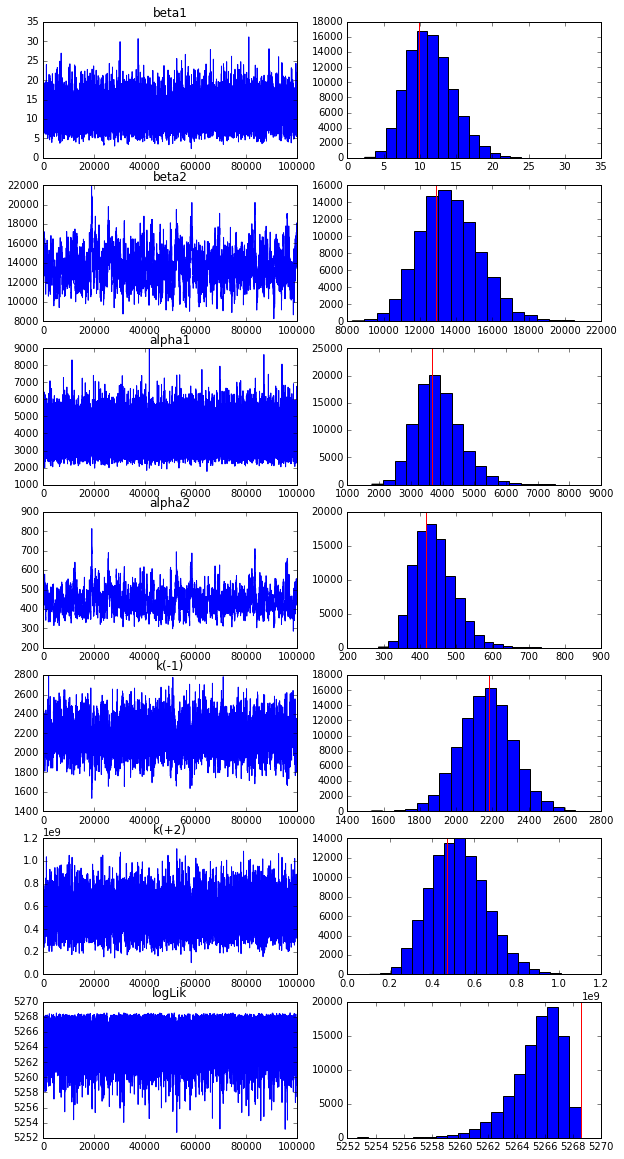

In [41]:
burnin = int(N / 2)
count = 1
S = S1[: , 5::6]
r = len(S)
fig = plt.figure(figsize = (10,20))
for i in range(r):
    ax1 = fig.add_subplot(r, 2, count)
    ax1.plot(S[i])
    ax1.set_title(theta_names[i])
    #ax1.set_xlabel('Iteration')
    
    count += 1
    ax2 = fig.add_subplot(r, 2, count)
    ax2.hist(S[i, burnin:], bins=20)
    ax2.axvline(x=Xmax[i], color='r')
    count += 1

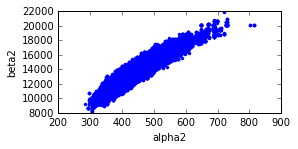

In [37]:
fig = plt.figure(figsize = (4,4))
ax = fig.add_subplot(211)
ax.plot(S[3], S[1], '.')
ax.set_xlabel('alpha2')
ax.set_ylabel('beta2')

In [38]:
def autocorrelation(X):
    X = X - np.mean(X)
    acf = np.correlate(X, X, mode='full')
    return acf[int(acf.size/2) : ] / acf[int(acf.size / 2)]

(0, 400)

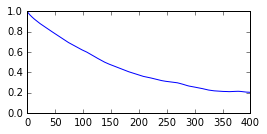

In [22]:
fig = plt.figure(figsize = (4,4))
ax = fig.add_subplot(211)
ax.plot(autocorrelation(S[3]))
ax.set_ylim(0, 1)
ax.set_xlim(0, 400)